# 01 Trips

In this notebook, the 2013 Chicago taxi trips dataset is prepared and cleaned for later usage.

In [1]:
## Import libraries
## Until WS05
import numpy as np
import pandas as pd
import datetime

## Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## For saving files
from pathlib import Path 

### Get Data

In [ ]:
## Load file
## Other imports possible (e.g. pyArrow)
#df_trips = pd.read_csv("Taxi_Trips_-_2013.csv")
df_trips = pd.read_csv("Taxi_Trips_-_2013.csv", parse_dates=['Trip Start Timestamp'], engine="pyarrow")
print("Number of rows:    ", len(df_trips))
print("Number of columns: ", len(df_trips.columns))
df_trips.head(5)

Now, we remove all columns that do not offer any kind of additional and potentially important information, as well as all rows that do not have actual values for Trip Seconds or Trip Miles.

In [3]:
## Drop columns
df_trips = df_trips.drop(['Trip End Timestamp','Extras', 'Payment Type', 'Company', 'Fare', 'Tips', 'Tolls', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude'], axis=1)

## Drop rows mit NaN or negative / 0 values
df_trips = df_trips.dropna(subset=['Trip Seconds', 'Trip Miles'])
df_trips = df_trips[(df_trips[['Trip Seconds','Trip Miles']] > 0).all(axis=1)]

In [4]:
df_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15077204 entries, 0 to 27217707
Data columns (total 12 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Trip ID                     object 
 1   Taxi ID                     object 
 2   Trip Start Timestamp        object 
 3   Trip Seconds                float64
 4   Trip Miles                  float64
 5   Pickup Census Tract         float64
 6   Dropoff Census Tract        float64
 7   Pickup Community Area       float64
 8   Dropoff Community Area      float64
 9   Trip Total                  float64
 10  Pickup Centroid Location    object 
 11  Dropoff Centroid  Location  object 
dtypes: float64(7), object(5)
memory usage: 1.5+ GB


We can see that the timestamps are not yet in datetime format, and the trip distance is given in miles which is harder to interpret for the target audience (German car manufacturer). 

In [5]:
## Convert from miles to kilometers
df_trips['Trip Miles'] = df_trips['Trip Miles'] * 1.609344
df_trips.rename(columns={"Trip Miles": "Trip Kilometers"}, inplace = True)
df_trips.head(5)

,Trip ID,Taxi ID,Trip Start Timestamp,Trip Seconds,Trip Kilometers,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Trip Total,Pickup Centroid Location,Dropoff Centroid Location
0,f4eeac57641ccafac957e7640c59be67b3d235d9,1db11e4e66375f35ed6a59eb06eb997fc7e23e3fdcbb3b...,2013-01-20 01:15:00,300.0,1.448410,1.703183e+10,1.703183e+10,28.0,28.0,6.45,POINT (-87.6572331997 41.8852813201),POINT (-87.6572331997 41.8852813201)
1,600ea9d83f5fd1b07d698d7a8e4d132c146b3d4c,a0a66f6e978125e040111831d60457ff2551356865bd69...,2013-02-19 10:15:00,540.0,2.092147,1.703132e+10,1.703108e+10,32.0,8.0,7.25,POINT (-87.6209929134 41.8849871918),POINT (-87.6262105324 41.8991556134)
2,f20e25252ad57949c37aabdc8d4ad3102ecae22f,4fdfda1ef9a53850fc350d2834bfd9086e4a622f5e06cd...,2013-03-04 17:30:00,300.0,1.287475,1.703108e+10,1.703108e+10,8.0,8.0,6.45,POINT (-87.6188683546 41.8909220259),POINT (-87.6291051864 41.9002212967)
3,534eafce867e1da9a4e298f41f997098b7ade02d,fd3dde755823d853a88fa12d98777b10b5708426e575db...,2013-02-28 12:45:00,720.0,4.345229,NaN,NaN,34.0,32.0,11.85,POINT (-87.6339734222 41.8420761168),POINT (-87.6251921424 41.8788655841)
4,0c883ed5c2d7a684bdf11071cea591bc72354b6c,12f6dc49f676b830a5b2c718a872f31d784c5e94aae68c...,2013-02-19 15:00:00,120.0,0.482803,1.703108e+10,1.703108e+10,8.0,8.0,3.85,POINT (-87.6262105324 41.8991556134),POINT (-87.6266589003 41.90752007470001)


With the first steps of data preparation done, let us have a look at the distribution of trip duration and trip length.

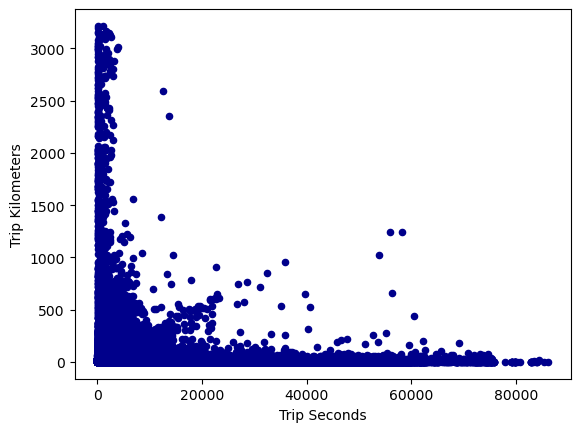

In [6]:
## Draw scatterplot
ax1 = df_trips.plot.scatter(x='Trip Seconds',
                      y='Trip Kilometers',
                      c='DarkBlue')

We can see that there is a number of trips with a high trip duration and/or high trip length. In some cases, the respective ratio is also very unlikely to happen in the real world (e.g. 200 kilometers in less than 3600 seconds = 1 hour or only very few kilometers in more than 10800 seconds = 3 hours). Moreover, even some of these outliers were real, they would occur only very seldomly in the real world. Therefore, we exclude trips with extreme durations or lengths.

In [7]:
## Show maximum quantiles
df_trips['Trip Seconds'].quantile([.9,.95,.96,.97,.98,.99,1])

0.90     1560.0
0.95     2100.0
0.96     2280.0
0.97     2520.0
0.98     2880.0
0.99     3480.0
1.00    86220.0
Name: Trip Seconds, dtype: float64

In [8]:
## Show maximum quantiles
df_trips['Trip Kilometers'].quantile([.9,.95,.96,.97,.98,.99,1])

0.90      16.415309
0.95      27.680717
0.96      28.485389
0.97      28.968192
0.98      30.416602
0.99      43.452288
1.00    3215.630246
Name: Trip Kilometers, dtype: float64

When looking at the quantiles and logical durations and lengths of taxi trips, cutoff values of one hour (= 3600 seconds) and 30 kilometers appear to be reasonable.

In [9]:
df_trips = df_trips[(df_trips[['Trip Seconds']] <= 3600).all(axis=1)]
df_trips = df_trips[(df_trips[['Trip Kilometers']] <= 30).all(axis=1)]

In addition, some entries that are short in duration and/or length might be faulty, as well: When trips are shorter than a minute or 100 meters, for example.

In [10]:
## Show minimum quantiles
df_trips['Trip Seconds'].quantile([.0,.01,.02,.03,.04,.05,0.1])

0.00      1.0
0.01    120.0
0.02    120.0
0.03    120.0
0.04    180.0
0.05    180.0
0.10    240.0
Name: Trip Seconds, dtype: float64

In [11]:
## Show minimum quantiles
df_trips['Trip Kilometers'].quantile([.0,.01,.02,.03,.04,.05,0.1])

0.00    0.016093
0.01    0.128748
0.02    0.160934
0.03    0.160934
0.04    0.160934
0.05    0.160934
0.10    0.321869
Name: Trip Kilometers, dtype: float64

In [12]:
df_trips = df_trips[(df_trips[['Trip Seconds']] >= 60).all(axis=1)]
df_trips = df_trips[(df_trips[['Trip Kilometers']] >= 0.1).all(axis=1)]

In [13]:
## Add unique index 
df_trips['index'] = range(0, len(df_trips))
df_trips = df_trips.set_index('index')
df_trips

,Trip ID,Taxi ID,Trip Start Timestamp,Trip Seconds,Trip Kilometers,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Trip Total,Pickup Centroid Location,Dropoff Centroid Location
index,,,,,,,,,,,,
0,f4eeac57641ccafac957e7640c59be67b3d235d9,1db11e4e66375f35ed6a59eb06eb997fc7e23e3fdcbb3b...,2013-01-20 01:15:00,300.0,1.448410,1.703183e+10,1.703183e+10,28.0,28.0,6.45,POINT (-87.6572331997 41.8852813201),POINT (-87.6572331997 41.8852813201)
1,600ea9d83f5fd1b07d698d7a8e4d132c146b3d4c,a0a66f6e978125e040111831d60457ff2551356865bd69...,2013-02-19 10:15:00,540.0,2.092147,1.703132e+10,1.703108e+10,32.0,8.0,7.25,POINT (-87.6209929134 41.8849871918),POINT (-87.6262105324 41.8991556134)
2,f20e25252ad57949c37aabdc8d4ad3102ecae22f,4fdfda1ef9a53850fc350d2834bfd9086e4a622f5e06cd...,2013-03-04 17:30:00,300.0,1.287475,1.703108e+10,1.703108e+10,8.0,8.0,6.45,POINT (-87.6188683546 41.8909220259),POINT (-87.6291051864 41.9002212967)
3,534eafce867e1da9a4e298f41f997098b7ade02d,fd3dde755823d853a88fa12d98777b10b5708426e575db...,2013-02-28 12:45:00,720.0,4.345229,NaN,NaN,34.0,32.0,11.85,POINT (-87.6339734222 41.8420761168),POINT (-87.6251921424 41.8788655841)
4,0c883ed5c2d7a684bdf11071cea591bc72354b6c,12f6dc49f676b830a5b2c718a872f31d784c5e94aae68c...,2013-02-19 15:00:00,120.0,0.482803,1.703108e+10,1.703108e+10,8.0,8.0,3.85,POINT (-87.6262105324 41.8991556134),POINT (-87.6266589003 41.90752007470001)
...,...,...,...,...,...,...,...,...,...,...,...,...
14576275,3d427552dcbe75ceed9988f8d0dc28ea385b75ff,11cec1092eb4f4b50433778d436f251983dd37d567f709...,2013-12-11 22:00:00,1320.0,25.105766,1.703108e+10,1.703177e+10,8.0,NaN,32.65,POINT (-87.6188683546 41.8909220259),POINT (-87.8773053996 41.9827750091)
14576276,5381c7d996b05f0396560571d1b509891f85951c,93930278eb7df9672cdc277c92e59dae0f82116868ce1c...,2013-08-23 20:15:00,960.0,0.160934,1.703184e+10,1.703108e+10,24.0,8.0,12.05,POINT (-87.6536139825 41.8983058696),POINT (-87.6262149064 41.8925077809)
14576277,5c71de11eff2d2083e0656669eb8bd95752389fe,2354c93bbaa7dac1e0d85d0bca366db1f91abf56b9731a...,2013-12-11 19:30:00,360.0,2.574950,1.703108e+10,1.703107e+10,8.0,7.0,6.65,POINT (-87.6266589003 41.90752007470001),POINT (-87.6341560931 41.922082541)


In [15]:
df_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14576280 entries, 0 to 14576279
Data columns (total 12 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Trip ID                     object        
 1   Taxi ID                     object        
 2   Trip Start Timestamp        datetime64[ns]
 3   Trip Seconds                float64       
 4   Trip Kilometers             float64       
 5   Pickup Census Tract         float64       
 6   Dropoff Census Tract        float64       
 7   Pickup Community Area       float64       
 8   Dropoff Community Area      float64       
 9   Trip Total                  float64       
 10  Pickup Centroid Location    object        
 11  Dropoff Centroid  Location  object        
dtypes: datetime64[ns](1), float64(7), object(4)
memory usage: 1.4+ GB


Mehr rauswerfen? Round trips (also Start GPS = End GPS rauswerfen?) Datetime umwandeln

In [18]:
## Save as pickle
import pickle

# Saving
pickle.dump(df_trips, open("trips.pkl","wb"))